In [1]:
import NN_evaluation
import matplotlib.pyplot as plt

In [3]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import torch
import pandas as pd
import NN_classes
import training_methods
import time
import numpy as np

sc = "sc01"
period = "2030"
case = "RTS24"

folder = f"../Data/{case}_DC_fy"

all_executions = DataLoading.list_executions(folder=folder, per=period, sc=sc)
executions_start = 0
executions_end = len(all_executions)
executions = all_executions[executions_start:executions_end]
te_s = 1/4
val_s = te_s/(1-te_s)
outp = "SystemCosts"
val_s_name = round(val_s,2)

nb_hours_list = [24 * i for i in range(1,9,2)] + [24 * i for i in range(10,150,20)]
# nb_hours_list = [24 * i for i in range(1,2,2)]
#nb_hours_list = [24 * i for i in range(1,3,2)]
#exec_name = f"rand_days_and_hours_{case}_DC_{te_s}_v{val_s_name}_PF_{executions_start}_{executions_end}"


dfs_in_full, dfs_out_full, dfs_inter_full = DataLoading.load_data_ext_out(folder, executions, period, sc, ["PowerFlow"], outp)
dfs_inter_j_full = DataLoading.join_frames_inter_layer(dfs_inter_full,all_executions)
dfs_inter_j_full = DataLoading.trim_columns_to_common(dfs_inter_j_full)

#Save the full datasets as pytorch tensors for informative loss calculation afterwards
t_in_fy, t_out_fy, t_inter_fy, maxs = DataLoading.concat_all_exec_fy(dfs_in_full, dfs_out_full, dfs_inter_j_full,all_executions)
results = pd.DataFrame()
i = 0

selection_methods = ["Days","Hours"]
selection_sets = [(selection_method,nb_hours) for nb_hours in nb_hours_list for selection_method in selection_methods]
selection_sets.append(("Weeks",24*7*12))

print("Amount of nb_hours: ", len(nb_hours_list), nb_hours_list)
for selection_set in selection_sets[-1:]:
    selection_method,nb_hours = selection_set[0],selection_set[1]
    exec_name = f"rand_{selection_method}_{case}_DC_{te_s}_v{val_s_name}_PF_{executions_start}_{executions_end}"
    folder_to_save = f"{exec_name}"

    # Select subset for the training process
    if selection_method == "Hours":
        # Method = random hours
        indices = DataLoading.get_random_hours_indices(nb_available=len(dfs_in_full[executions[0]]), nb_selected=nb_hours)
        nb_hours_used = nb_hours
    elif selection_method == "Days":
        nb_days = int(nb_hours/24)
        indices = DataLoading.get_random_days_indices(hours_available = len(dfs_in_full[executions[0]]),nb_selected = nb_days,hours_in_day=24,sorted = True)
        nb_hours_used= nb_days*24

        assert(nb_hours_used == len(indices))
    elif selection_method == "Weeks":
        indices = DataLoading.get_random_week_per_month_indices(df= dfs_out_full[executions[0]],hours_in_day=24, days_in_week=7)
        nb_hours_used = len(indices)
    else:
        raise Error(f"Selection method {selection_method} not implemented")
    # print(indices)
    print(nb_hours_used, len(indices), selection_method)
    dfs_in, dfs_out, dfs_inter_j = DataLoading.return_selection(dfs_dict_list=[dfs_in_full, dfs_out_full, dfs_inter_j_full],
                                                                indices=indices)
    # Convert to pytorch tensors
    ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, executions, te_s, val_s)

    # Concat and normalize
    d_ft_in, d_ft_out, d_ft_inter, maxs_1 = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, executions,normalize= False)
    for setname in ["train","test","val"]:
        d_ft_in[setname] = torch.nan_to_num(d_ft_in[setname]/maxs["in"])
        d_ft_inter[setname] = torch.nan_to_num(d_ft_inter[setname]/maxs["inter"])
        d_ft_out[setname] = torch.nan_to_num(d_ft_out[setname]/maxs["out"])
    # print(d_ft_in["train"].shape)
    # print(d_ft_in["test"].shape)
    # print(d_ft_in["val"].shape)


    # Create TensorDatasets
    train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float(), d_ft_inter['train'])
    validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float(), d_ft_inter['val'].float())

    # Perform the actual loop that checks multiple hyperparams

    nbs_hidden = [(0,0)]  #
    # nbs_hidden = [(0,0)]

    dors = [0]
    relu_outs = [False]

    batch_sizes = [128]
    # batch_sizes = [128]

    learning_rates = [0.0025 * 2 ** i for i in range(-1, 1, 1)]
    #learning_rates = [0.0025*2**i for i in range(0,1,1)]

    #nbs_e = [128,256]
    nbs_e = [64]

    #alphas = [0,1]
    alphas = [0]
    beta = 1

    MAEs = [False]


    hp_sets = [(nb_h, dor, relu_out, bs, lr, nb_e, alpha, MAE) for nb_h in nbs_hidden for dor in dors for relu_out in
               relu_outs for bs in batch_sizes for lr in learning_rates for nb_e in nbs_e
               for alpha in alphas for MAE in MAEs]
    print("Number of hyperparameters: " ,len(hp_sets))
    for hp_set in hp_sets:
        # Initialize hyperparameter from hp_set
        nb_hidden, dor, relu_out, bs, lr, nb_e, alpha, MAE = hp_set

        # Create training and validation loaders based on batch size
        training_loader = DataLoader(train, batch_size=bs,shuffle = True)
        validation_loader = DataLoader(validation, batch_size=bs,shuffle = True)

        # Initialize loss functions
        loss_fn = NN_classes.create_custom_loss(alpha=alpha, beta=beta, MAE=MAE)
        loss_t_mse = torch.nn.MSELoss()
        loss_mae = torch.nn.L1Loss()

        #Create hidden sizes vector
        if nb_hidden == (3,1):
            hs = [60,60,60,38,19]
        else:
            hs = None

        # Create model based on hyperparameter set
        m = NN_classes.create_model(nb_hidden, d_ft_in['train'].shape[1], dropout_ratio=dor, relu_out=relu_out, inter=True,
                                    inter_size=dfs_inter_j["Network_Existing_Generation_Full"].shape[1],hidden_sizes = hs)

        # Create model name for saving and loading
        m_name = f"OE_{nb_hours_used}hours_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor_{relu_out}ro_{bs}bs_{alpha}ill_{MAE}MAE"
        # Create optimizer based on learning rate
        optimizer = torch.optim.Adam(m.parameters(), lr=lr)
        # Train the actual model
        t_start_train = time.perf_counter()
        train_loss_1 = training_methods.train_multiple_epochs(
            nb_e, m, training_loader, validation_loader, loss_fn, optimizer, m_name,
            folder_to_save, True)[0]
        t_stop_train = time.perf_counter()

        for mt in ["min_val", "all_epochs"]:
            t_start_eval = time.perf_counter()
            path = f"trained_models/{folder_to_save}/{mt}/model_{m_name}.pth"

            # Retreive model state and set to evaluation mode
            m.load_state_dict(torch.load(path))
            m.eval()

            # Calculate losses
            test_predictions = m(d_ft_in["test"].float())
            test_loss = loss_fn(test_predictions[0].squeeze(), d_ft_out["test"], test_predictions[1].squeeze(),
                                d_ft_inter["test"])
            test_loss_t_mse = loss_t_mse(test_predictions[0].squeeze(), d_ft_out["test"])
            test_loss_mae = loss_mae(test_predictions[0].squeeze(), d_ft_out["test"])
            manual_diff = test_predictions[0].detach().numpy().transpose() - d_ft_out["test"].numpy()
            Te_l_mae_man = np.mean(np.abs(manual_diff))

            train_predictions = m(d_ft_in["train"].float())
            train_loss = loss_fn(train_predictions[0].squeeze(), d_ft_out["train"], train_predictions[1].squeeze(),
                                 d_ft_inter["train"])
            train_loss_t_mse = loss_t_mse(train_predictions[0].squeeze(), d_ft_out["train"])
            train_loss_mae = loss_mae(train_predictions[0].squeeze(), d_ft_out["train"])

            validation_prediction = m(d_ft_in["val"].float())
            validation_loss = loss_fn(validation_prediction[0].squeeze(), d_ft_out["val"],
                                      validation_prediction[1].squeeze(), d_ft_inter["val"])
            validation_loss_t_mse = loss_t_mse(validation_prediction[0].squeeze(), d_ft_out["val"])
            validation_loss_mae = loss_mae(validation_prediction[0].squeeze(), d_ft_out["val"])


            t_stop_eval = time.perf_counter()

            fy_prediction = m(t_in_fy.float())

            fy_l = loss_fn(fy_prediction[0].squeeze(), t_out_fy,fy_prediction[1].squeeze(),t_inter_fy)
            fy_l_mse = loss_t_mse(fy_prediction[0].squeeze(), t_out_fy)
            fy_l_mae = loss_mae(fy_prediction[0].squeeze(), t_out_fy)

            manual_diff = fy_prediction[0].detach().numpy().transpose() - t_out_fy.numpy()
            fy_l_mae_man = np.mean(np.abs(manual_diff))

            # Calculate some calculation times
            t_train = t_stop_train - t_start_train
            t_eval = t_stop_eval - t_start_eval

            #Calculate some losses manually


            # Finally, save all desired values in a dataframe
            r = pd.DataFrame({"Model_type": [nb_hidden],
                              "Dor": dor,
                              "Relu_out": relu_out,
                              "Batch_size": bs,
                              "Lr": lr,
                              "Epochs": nb_e,
                              "Min_val": mt,
                              "Nb_hours_used":nb_hours_used,
                              "Sel_method" : selection_method,
                              "Tr_l": train_loss.item(),
                              "Te_l": test_loss.item(),
                              "V_l": validation_loss.item(),
                              "Tr_l_mse": train_loss_t_mse.item(),
                              "Te_l_mse": test_loss_t_mse.item(),
                              "V_l_mse": validation_loss_t_mse.item(),
                              "Tr_l_mae": train_loss_mae.item(),
                              "Te_l_mae": test_loss_mae.item(),
                              "Te_l_mae_man": Te_l_mae_man ,
                              "V_l_mae": validation_loss_mae.item(),
                              "fy_l":fy_l.item(),
                              "fy_l_mse":fy_l_mse.item(),
                              "fy_l_mae":fy_l_mae.item(),
                              "fy_l_mae_man":fy_l_mae_man,
                              "Train_time": t_train,
                              "Eval_time": t_eval,
                              "alpha": alpha,
                              "beta": beta,
                              "MAE": MAE,
                              "Test size": te_s,
                              "Val size": val_s
                              }
                             , index=[i])
            i += 1
            results = pd.concat([results, r])
        results.to_csv(f"Loss_results_csv/{exec_name}.csv")



input_f_sc01_Network_Existing_Generation_Full_2030.csv
90
input_f_sc01_Network_Full_Generation_Full_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_101_N_102_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_101_N_103_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_101_N_105_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_102_N_104_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_102_N_106_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_103_N_109_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_103_N_124_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_104_N_109_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_105_N_110_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_106_N_108_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_106_N_110_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_107_N_108_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_108_N_109_cac1_2030.csv
90
input_f_sc01_PINT_Network_Line_In_N_108_N_110_cac1_2030.csv
90
input_

In [8]:
np_pred = (fy_prediction[0]*maxs["out"]).detach().numpy()
np_out = (t_out_fy*maxs["out"]).numpy()

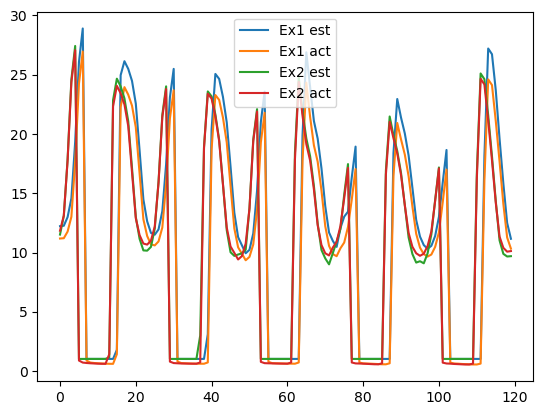

In [27]:
import matplotlib.pyplot as plt
s=0
e= 120
ly = 8736
nby = 3
offs = ly*nby
offs2 = 2
plt.plot(np_pred[s:e],label= "Ex1 est")
plt.plot(np_out[s:e],label= "Ex1 act")
plt.plot(np_pred[s+offs+offs2:e+offs+offs2],label= "Ex2 est")
plt.plot(np_out[s+offs+offs2:e+offs+offs2],label= "Ex2 act")
plt.legend()

In [35]:
(t_out_fy[0:ly] - t_out_fy[ly*3:ly*4]).sum()*maxs["out"]

tensor(-452.8204, dtype=torch.float64)